# Simulations of assimilation and transpiration rates.

This notebook calculates the photosynthetic carbon demand ($A_n$) following Farquhar et al. (1980) with the corrections by Leuning (1995). It couples carbon assimilation and stomatal conductivity models, and then simulates transpiration rates ($T$) with the Penman-Monteith model.

Bartlett, M. S., Vico, G., & Porporato, A. (2014). Coupled carbon and water fluxes in CAM photosynthesis: modeling quantification of water use efficiency and productivity. Plant and Soil, 383(1–2), 111–138. https://doi.org/10.1007/s11104-014-2064-2

Finally, it testes the effect of the stochstic component of CO$_2$ in $T$ and $A_n$.

## Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy
from sympy import *
from sympy import Min
import glob
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import scipy 
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

## Paths

In [2]:
pathr='/home/_ehoyos/Documents/Data_CO2/Final_info/' # path to read the data.
paths='/home/_ehoyos/Documents/Data_CO2/Final_results/' # path to save the results.

## Parameter values for each model

In [3]:
# *****************************************************************************************************************
# Farquhar model - CO2 assimilation
# *****************************************************************************************************************
#Symbols
oi=symbols('o_i') # oxygen concentration [mol mol−1].
Kc0=symbols('K_{c0}') # Michaelis constant for CO2 at T0 [μmol mol−1].
Ko0=symbols('K_{o0}') # Michaelis constant for O2 at T0 [μmol mol−1].
Hkc=symbols('H_{kc}') # activation energy for Kc [J mol-1].
Hko=symbols('H_{ko}') # activation energy for Ko [J mol-1].
r0=symbols('gamma_0')# CO2 compensation point at T0 [μmol mol−1].
r1=symbols('gamma_1') # [K-1].
r2=symbols('gamma_2') # [K-2].
Vcmax0=symbols('V_{c,max0}') # [μmol m−2 s−1].
Hvv=symbols('H_{vv}') # activation energy for Vcmax [J mol-1].
Svv=symbols('S_{vv}') # entropy term for carboxylation [J mol-1].
Svj=symbols('S_{vj}') # entropy term for electron transport [J mol-1].
Hdv=symbols('H_{dv}') # deactivation energy for Vcmax [J mol-1].
Jmax0=symbols('J_{max0}') # [μmol m−2 s−1].
Hvj=symbols('H_{vj}') # activation energy for Jmax [J mol-1 k-1]
T0=symbols('T_0') # reference temperature [K].
R=symbols('R') # universal gas constant [J mol−1 K−1].
Hdj=symbols('H_{dj}') # deactivation energy for Jmax [J mol-1].
phi=symbols('phi') # solar radiation [W m-2].
Ta=symbols('T_a') # atmospheric temperature [K]. 
Tl=symbols('T_l') # leaf temperature [K]. 
 
# Values
# These values are the same published in tables 2 and 3 of Bartlett et al. 2014.
oi=0.209 # oxygen concentration [mol mol−1].
Kc0=302. # Michaelis constant for CO2 at T0 [μmol mol−1].
Ko0=256. # Michaelis constant for O2 at T0 [μmol mol−1].
Hkc=59430. # activation energy for Kc [J mol-1].
Hko=36000. # activation energy for Ko [J mol-1].
r0=34.6 # CO2 compensation point at T0 [μmol mol−1].
r1=0.0451 # [K-1].
r2=0.000347 # [K-2].
Vcmax0=19.5 # [μmol m−2 s−1].
Hvv=72000 # activation energy for Vcmax [J mol-1].
Svv=649. # entropy term for carboxylation [J mol-1].
Svj=646. # entropy term for electron transport [J mol-1].
Hdv=200000 # deactivation energy for Vcmax [J mol-1].
Jmax0=2*Vcmax0 # [μmol m−2 s−1].
Hvj=50000. # activation energy for Jmax [J mol-1 k-1]
T0=293.2 # reference temperature [K].
R=8.31 # universal gas constant [J mol−1 K−1].
Hdj=200000 # deactivation energy for Jmax [J mol-1].
#phi=phii # solar radiation [W m-2].***
#phi_J=phi/1e6 # solar radiation [MJ s-1 m-2].
#Ta_c=Tai # atmospheric temperature [C].*** 
#Ta=Ta_c+273.15 # atmospheric temperature [K].*** 
#Tl=5+Ta # leaf temperature [K].*** 
#***imposed values.

# *****************************************************************************************************************
# Stomatal conductivity model
# *****************************************************************************************************************
# Symbols
ga=symbols('g_a') # atmospheric conductance [m s-1].
a1=symbols('a_1') # empirical constant [-].
Dx=symbols('D_x') # empirical constant [kPa] (Leuning 1995).
D=symbols('D') # vapor pressure deficit [kPa].***
Pa=symbols('P_a') # atmospheric pressure [Pa] (Pa=J m-3).

# Values
# These values are the same published in tables 1 and 2 of Bartlett et al. 2014..
a1=6.4 #10 # empirical constant [-] (Leuning 1995).
Dx=500/1000 #500/1000 # empirical constant [kPa] (Leuning 1995).
D=1000/1000#2000/1000 # vapor pressure deficit [kPa].***
Pa=101300 # atmospheric pressure [Pa] (Pa=J m-3).
ga=29/1000 # atmospheric conductance [m s-1].
gb=29/1000. # Leaf boundary layer conductance [m s-1].
gba=ga*gb/(ga+gb)# series between the conductance of the leaf boundary layer and of the atmospheric boundary layer [m s-1].
a2=15 # empirical constant of the stomatal conductance model [-].

# *****************************************************************************************************************
# Penman-Monteith model - Transpiration
# *****************************************************************************************************************
cp=symbols('c_p') # specific heat at constant pressure [MJ kg-1 K-1].
lhv=symbols('lambda_w') # latent heat of water vaporization [MJ kg−1].
eps=symbols('e') # ratio molecular weight of water vapour/dry air [-].
a_den=symbols('rho_a') # air density [kg m-3].
w_den=symbols('rho_w')# water density [kg m-3].
LAI=symbols('LAI') # leaf area index [-].

# Evapotranspiration models
cp=1.013e-3 # specific heat at constant pressure [MJ kg-1 K-1].
lhv=2.45 # latent heat of water vaporization [MJ kg−1].
eps=0.622 # ratio molecular weight of water vapour/dry air [-].
a_den=1.2 # air density [kg m-3].
w_den=997# water density [kg m-3].
LAI=1.4 # leaf area index [-].

## Read data of the selected site

In [56]:
sitef='ATTO' # name of site to analyze.

files=glob.glob(pathr+"/*.csv")
names=["" for i in range(len(files))] # names of ICOS sites.
for i in range(len(files)):
    names[i]=files[i].split('/')[len(files[i].split('/'))-1].split('.')[0].split('_')[0]
ii=names.index(sitef)
print(names[ii])

dataf=pd.read_csv(files[ii],skiprows=10)
dataf["date"]=pd.to_datetime(dataf["date"])
line=open(files[ii],"r").readlines()[0:10]
code=line[1].split(',')[1].strip()
site=line[0].split(',')[1].strip()
country=line[2].split(',')[1].strip()
latitude=line[3].split(',')[1].strip()
longitude=line[4].split(',')[1].strip()
altitude=line[5].split(',')[1].strip()
units=line[6].split(',')[1].strip()
nHeights=int(line[7].split(',')[1].strip())
Temp=line[8].split(',')[1].strip() # atmospheric temperature [C]
Rad=line[9].split(',')[1].strip() # solar radiation [W m-2].
titles=dataf.columns
phi=float(Rad) ; Ta_c=float(Temp)
phi_J=phi/1e6 # solar radiation [MJ s-1 m-2].
Ta=Ta_c+273.15 # atmospheric temperature [K].
Tl=5+Ta # leaf temperature [K].***
gba_m=gba*Pa/(R*Ta)*3600

titlesall=titles[7+2*nHeights:7+2*nHeights+nHeights]
titlesdet=titles[7+3*nHeights:7+3*nHeights+nHeights]

heights=np.zeros(nHeights)
for i in range(nHeights): heights[i]=float(titlesdet[i].split('_')[1])
    
### time resolution
w=dataf['date'][1].minute-dataf['date'][0].minute
if w==30:
    dt=0.5 #delta of time [d].
    xx=48.
elif w==0:
    dt=1
    xx=24.
else:
    print('dt is not 1 h or 0.5 h')


ATTO


In [57]:
heights

array([ 4., 24., 38., 53., 79.])

## Definition of variables

In [58]:
ca=symbols('c_a') # atmospheric carbon concentration [μmol mol-1].
ci=symbols('c_i') # mesophyll carbon concentration [μmol mol-1].
An=symbols('A_n') # carbon assimilation [μmolCO2 m-2 s-1].
cs=symbols('c_s') # atmospheric concentration of CO2 outside the stomatal cavity [μmol mol-1].

## Equations

In [59]:
# *****************************************************************************************************************
# Sub-equations 
# *****************************************************************************************************************

# CO2 compensation point ($\Gamma_0$)
ra=r0*(1+r1*(Tl-T0)+r2*(Tl-T0)**2) # [μmol mol-1].

# Michelis-Menten constants
Kc=Kc0*exp(Hkc/(R*T0)*(1-T0/Tl)) # [μmol mol−1].

Ko=Ko0*exp(Hko/(R*T0)*(1-T0/Tl)) # [μmol mol−1].

# Maximum carboxylation rate
Vcmax=Vcmax0*exp(Hvv/(R*T0)*(1-T0/Tl))/(1+exp((Svv*Tl-Hdv)/(R*Tl)))*3600 # [μmol m-2 h-1]

# maximum electron transport rate  driving regeneration of RuBP
Jmax=Jmax0*exp(Hvj/(R*T0)*(1-T0/Tl))/(1+exp((Svj*Tl-Hdj)/(R*Tl)))*3600 # [μmol m-2 h-1]

# Amount of solar radiation converted to μmol electrons m−2 s−1.
Q=phi*4.6*3600 # [μmol m-2 h-1] https://www.controlledenvironments.org/wp-content/uploads/sites/6/2017/06/Ch01.pdf

# Electron transport rate.
J=min(Jmax,Q) # [μmol m-2 h-1]

# atmospheric conductance from [m s-1] to [mol m-2 s-1].
ga_m=ga*Pa/(R*Ta)*3600 # [mol m-2 h-1]

# *****************************************************************************************************************
# Equations with unknowns
# *****************************************************************************************************************

# Electron transport- (or light-) limited photosynthesis.
Aq=J/4*(ci-ra)/(ci+2*ra) # [μmol m-2 h-1]

# Rubisco-limited photosynthesis. 
Ac=Vcmax*(ci-ra)/(ci+Kc*(1+oi/Ko)) # [μmol m-2 h-1]

# Net photosynthetic demand for CO2 (Eq1).
#An=min(Aq,Ac) # [μmol m-2 h-1]

# Net photosynthetic demand for CO2 (Eq20.)
#An=ga_m*(ca-cs) # [μmol m-2 h-1]

# Atmospheric concentration of CO2 outside the stomatal cavity (Eq3).
#ci=cs*(1-1/a1*(1+D/Dx)) # [μmol mol-1]

## Equations system

In [60]:
Eq11=sympy.Eq(An-(J/4*(ci-ra)/(ci+2*ra)),0)
Eq12=sympy.Eq(An-(Vcmax*(ci-ra)/(ci+Kc*(1+oi/Ko))),0)
Eq2=sympy.Eq(An-(ga_m*(ca-cs)),0)
Eq3=sympy.Eq(ci-(cs*(1-1/a1*(1+D/Dx))),0)

sol1=sympy.solve([Eq11,Eq2,Eq3],[An,ci,cs])[0]
sol2=sympy.solve([Eq12,Eq2,Eq3],[An,ci,cs])[0]

## Saturation curves (CO$_2$ vs. $A_n$, $g_s$ and $T$) and 2nd derivatives

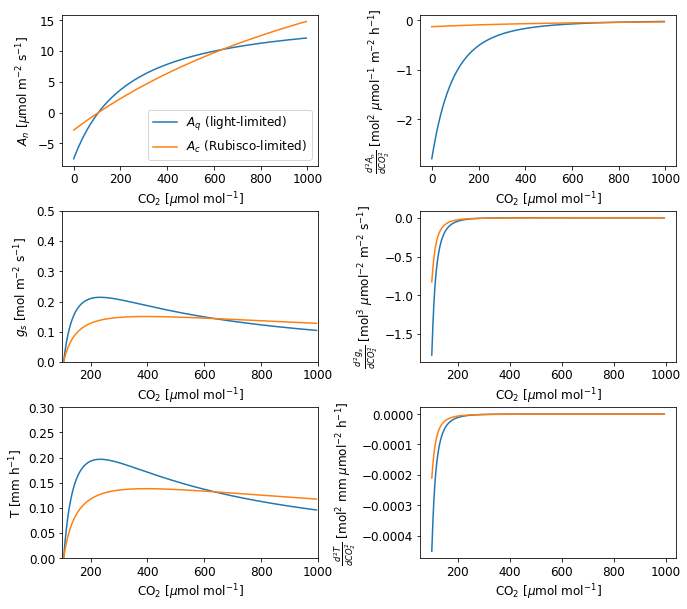

In [61]:
CO2_v=np.arange(0,1000,5)
An_v1=np.zeros(CO2_v.size);An_v2=np.zeros(CO2_v.size)
cs_v1=np.zeros(CO2_v.size);cs_v2=np.zeros(CO2_v.size)
plt.rcParams.update({'font.size':12})
fig,axs=plt.subplots(3,2,figsize=(11,10)) 
plt.rcParams.update({'font.size':12})


# Assimilation
for i in range(CO2_v.size):
    An_v1[i]=sol1[0].subs(ca,CO2_v[i])
    An_v2[i]=sol2[0].subs(ca,CO2_v[i])
    cs_v1[i]=sol1[2].subs(ca,CO2_v[i])
    cs_v2[i]=sol2[2].subs(ca,CO2_v[i])
    
x=CO2_v
y1=An_v1
y2=An_v2

An_spl1=UnivariateSpline(x,y1,s=0,k=4)
An_spl2=UnivariateSpline(x,y2,s=0,k=4)
An_spl1_1d=An_spl1.derivative(n=1);An_spl2_1d=An_spl2.derivative(n=1)
An_spl1_2d=An_spl1.derivative(n=2);An_spl2_2d=An_spl2.derivative(n=2)
x_range = np.linspace(x[0],x[-1],1000)
axs[0,0].plot(CO2_v,An_v1/3600,label='$A_q$ (light-limited)')
axs[0,0].plot(CO2_v,An_v2/3600,label='$A_c$ (Rubisco-limited)')
axs[0,0].set_xlabel('CO$_2$ [$\mu$mol mol$^{-1}$]')
axs[0,0].set_ylabel('$A_n$ [$\mu$mol m$^{-2}$ s$^{-1}$]')
axs[0,0].legend()

axs[0,1].plot(x_range,An_spl1_2d(x_range),label='$A_q$ (light-limited)')
axs[0,1].plot(x_range,An_spl2_2d(x_range),label='$A_c$ (Rubisco-limited)')
axs[0,1].set_xlabel('CO$_2$ [$\mu$mol mol$^{-1}$]')
axs[0,1].set_ylabel(r'$\frac{d^2A_n}{dCO_2^2}$ [mol$^{2}$ $\mu$mol$^{-1}$ m$^{-2}$ h$^{-1}$] ') 

# Stomatal conductance
gs_v1=1.6*a2*An_v1/((cs_v1-ra)*(1+D/Dx)) # [mol m-2 s-1]
gs_v2=1.6*a2*An_v2/((cs_v2-ra)*(1+D/Dx))


x=CO2_v[20:]
y1=gs_v1[20:]
y2=gs_v2[20:]
x_range = np.linspace(x[0],x[-1],1000)
gs_spl1=UnivariateSpline(x,y1,s=0,k=4)
gs_spl2=UnivariateSpline(x,y2,s=0,k=4)
gs_spl1_1d=gs_spl1.derivative(n=1);gs_spl2_1d=gs_spl2.derivative(n=1)
gs_spl1_2d=gs_spl1.derivative(n=2);gs_spl2_2d=gs_spl2.derivative(n=2)

axs[1,0].plot(CO2_v,gs_v1/3600,label='$A_q$ (light-limited)')
axs[1,0].plot(CO2_v,gs_v2/3600,label='$A_c$ (Rubisco-limited)')
axs[1,0].set_xlabel('CO$_2$ [$\mu$mol mol$^{-1}$]')
axs[1,0].set_ylabel('$g_s$ [mol m$^{-2}$ s$^{-1}$]')
axs[1,0].set_ylim(0,0.5)
axs[1,0].set_xlim(100,1000)

axs[1,1].plot(x_range,gs_spl1_2d(x_range),label='$A_q$ (light-limited)')
axs[1,1].plot(x_range,gs_spl2_2d(x_range),label='$A_c$ (Rubisco-limited)')
axs[1,1].set_xlabel('CO$_2$ [$\mu$mol mol$^{-1}$]')
axs[1,1].set_ylabel(r'$\frac{d^2g_s}{dCO_2^2}$ [mol$^{3}$ $\mu$mol$^{-2}$ m$^{-2}$ s$^{-1}$] ') 


# Transpiration

svp=2503.162*exp(17.27*Ta_c/(Ta_c+237.3))/(Ta_c+237.3)**2 # slope vapor pressure [kPa K-1].
psy=cp*Pa/1000/(lhv*eps) # psychrometric constant [kPa K-1].

ET_v1=(a_den*cp*D*gba_m+svp*phi_J)*gs_v1*(R*Ta/(3600*Pa))*LAI/(w_den*lhv*
                                                           (svp*gs_v1*(R*Ta/(3600*Pa))*LAI+psy*
                                                            (gba_m+gs_v1*(R*Ta/(3600*Pa))*LAI))) # [m s-1]

ET_v2=(a_den*cp*D*gba_m+svp*phi_J)*gs_v2*(R*Ta/(3600*Pa))*LAI/(w_den*lhv*
                                                           (svp*gs_v2*(R*Ta/(3600*Pa))*LAI+psy*
                                                            (gba_m+gs_v2*(R*Ta/(3600*Pa))*LAI))) # [m s-1]
x=CO2_v[20:]
y1=ET_v1[20:]*1000*3600
y2=ET_v2[20:]*1000*3600

ET_spl1=UnivariateSpline(x,y1,s=0,k=4)
ET_spl2=UnivariateSpline(x,y2,s=0,k=4)
ET_spl1_1d=ET_spl1.derivative(n=1);ET_spl2_1d=ET_spl2.derivative(n=1)
ET_spl1_2d=ET_spl1.derivative(n=2);ET_spl2_2d=ET_spl2.derivative(n=2)

axs[2,0].plot(CO2_v,ET_v1*1000*3600,label='$A_q$ (light-limited)')
axs[2,0].plot(CO2_v,ET_v2*1000*3600,label='$A_c$ (Rubisco-limited)')
axs[2,0].set_xlabel('CO$_2$ [$\mu$mol mol$^{-1}$]')
axs[2,0].set_ylabel('T [mm h$^{-1}$]')
axs[2,0].set_ylim(0.,0.30)
axs[2,0].set_xlim(100,1000)

axs[2,1].plot(x_range,ET_spl1_2d(x_range),label='$A_q$ (light-limited)')
axs[2,1].plot(x_range,ET_spl2_2d(x_range),label='$A_c$ (Rubisco-limited)')
axs[2,1].set_xlabel('CO$_2$ [$\mu$mol mol$^{-1}$]')
axs[2,1].set_ylabel(r'$\frac{d^2T}{dCO_2^2}$ [mol$^{2}$ mm $\mu$mol$^{-2}$ h$^{-1}$] ') 



plt.subplots_adjust(wspace=0.4,hspace=0.3)

## Simulations

In [62]:
nt=len(dataf)

An_det=np.empty((nHeights,nt)); An_sto=np.empty((nHeights,nt))
ci_det=np.empty((nHeights,nt)); ci_sto=np.empty((nHeights,nt))
cs_det=np.empty((nHeights,nt)); cs_sto=np.empty((nHeights,nt))
gs_det=np.empty((nHeights,nt)); gs_sto=np.empty((nHeights,nt))
ET_det=np.empty((nHeights,nt)); ET_sto=np.empty((nHeights,nt)) # ET [m s-1].


An_det[:]=np.nan; An_sto[:]=np.nan # CO2 assimilation using deterministic and deterministic+stochastic components [μmol m-2 h-1].
ci_det[:]=np.nan; ci_sto[:]=np.nan
cs_det[:]=np.nan; cs_sto[:]=np.nan
gs_det[:]=np.nan; gs_sto[:]=np.nan
ET_det[:]=np.nan; ET_sto[:]=np.nan

for j in range(2): # deterministic and stochastic 
    for jj in range(nHeights):
        if j==0:cav=dataf[titlesdet[jj]]
        if j==1:cav=dataf[titlesall[jj]]
        for k in range(nt):
            if j==0:
                if pd.notna(cav[k]):An_det[jj,k]=min(sol1[0].subs(ca,cav[k]),sol2[0].subs(ca,cav[k]))
                if pd.notna(cav[k]):ci_det[jj,k]=min(sol1[1].subs(ca,cav[k]),sol2[1].subs(ca,cav[k]))
                if pd.notna(cav[k]):cs_det[jj,k]=min(sol1[2].subs(ca,cav[k]),sol2[2].subs(ca,cav[k]))          
            if j==1:
                if pd.notna(cav[k]):An_sto[jj,k]=min(sol1[0].subs(ca,cav[k]),sol2[0].subs(ca,cav[k]))
                if pd.notna(cav[k]):ci_sto[jj,k]=min(sol1[1].subs(ca,cav[k]),sol2[1].subs(ca,cav[k]))
                if pd.notna(cav[k]):cs_sto[jj,k]=min(sol1[2].subs(ca,cav[k]),sol2[2].subs(ca,cav[k]))
        if j==0:
            dataf['An_'+str(heights[jj])+"_det"]=An_det[jj,]
            dataf['ci_'+str(heights[jj])+"_det"]=ci_det[jj,]
            dataf['cs_'+str(heights[jj])+"_det"]=cs_det[jj,]
        if j==1:
            dataf['An_'+str(heights[jj])+"_sto"]=An_sto[jj,]
            dataf['ci_'+str(heights[jj])+"_sto"]=ci_sto[jj,]
            dataf['cs_'+str(heights[jj])+"_sto"]=cs_sto[jj,]


for jj in range(nHeights):
    gs_det[jj,]=1.6*a2*An_det[jj,]/((cs_det[jj,]-ra)*(1+D/Dx))
    gs_sto[jj,]=1.6*a2*An_sto[jj,]/((cs_sto[jj,]-ra)*(1+D/Dx))
        
    ET_det[jj,]=(a_den*cp*D*gba_m+svp*phi_J)*gs_det[jj,]*(R*Ta/(3600*Pa))*LAI/(w_den*lhv*
                                                           (svp*gs_det[jj,]*(R*Ta/(3600*Pa))*LAI+psy*
                                                            (gba_m+gs_det[jj,]*(R*Ta/(3600*Pa))*LAI))) 
    ET_sto[jj,]=(a_den*cp*D*gba_m+svp*phi_J)*gs_sto[jj,]*(R*Ta/(3600*Pa))*LAI/(w_den*lhv*
                                                           (svp*gs_sto[jj,]*(R*Ta/(3600*Pa))*LAI+psy*
                                                            (gba_m+gs_sto[jj,]*(R*Ta/(3600*Pa))*LAI))) 
    dataf['T_'+str(heights[jj])+"_det"]=ET_det[jj,]*1000*3600
    dataf['T_'+str(heights[jj])+"_sto"]=ET_sto[jj,]*1000*3600
    dataf['gs_'+str(heights[jj])+"_det"]=gs_det[jj,]/3600
    dataf['gs_'+str(heights[jj])+"_sto"]=gs_sto[jj,]/3600
            
header='Site,'+site+'\nCode,'+code+'\nCountry,'+country+'\nLatitude,'+str(latitude)+'\nLongitude,'+str(longitude)+'\nAltitude,'+str(altitude)+'\nUnits,'+units+'\nnHeights,'+str(nHeights)+'\nTemp,'+str(Tmean.item())+'\nRad,'+str(Radmean.item())+'\n'+'\n'
with open(paths+code+'_An.csv', 'w') as fp:
    fp.write(header)
        
dataf.to_csv(paths+code+'_An_T.csv',header=True,mode='a') 
    
An_sto_cum=np.empty((nHeights,len(dataf))); An_det_cum=np.empty((nHeights,len(dataf))) 
An_sto_cum[:]=np.nan; An_det_cum[:]=np.nan
ET_sto_cum=np.empty((nHeights,len(dataf))); ET_det_cum=np.empty((nHeights,len(dataf))) 
ET_sto_cum[:]=np.nan; ET_det_cum[:]=np.nan

for i in range(nHeights): # nan positions coincide in both arrays.
    w=np.argwhere(np.isnan(An_det[i,])|np.isnan(An_sto[i,]))
    An_sto[i,w]=np.nan; An_det[i,w]=np.nan
    An_det_cum[i,]=np.nancumsum(An_det[i,]); An_sto_cum[i,]=np.nancumsum(An_sto[i,])
    w=np.argwhere(np.isnan(ET_det[i,])|np.isnan(ET_sto[i,]))
    ET_sto[i,w]=np.nan; ET_det[i,w]=np.nan
    ET_det_cum[i,]=np.nancumsum(ET_det[i,]); ET_sto_cum[i,]=np.nancumsum(ET_sto[i,])
    
diff_An=np.zeros(nHeights) 
diff_ET=np.zeros(nHeights)   
for i in range(nHeights):
    diff_An[i]=(1-An_det_cum[i,-1]/An_sto_cum[i,-1])
    diff_ET[i]=(1-ET_det_cum[i,-1]/ET_sto_cum[i,-1])   
    

## Dynamic differences

/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


0
0
0
1
1


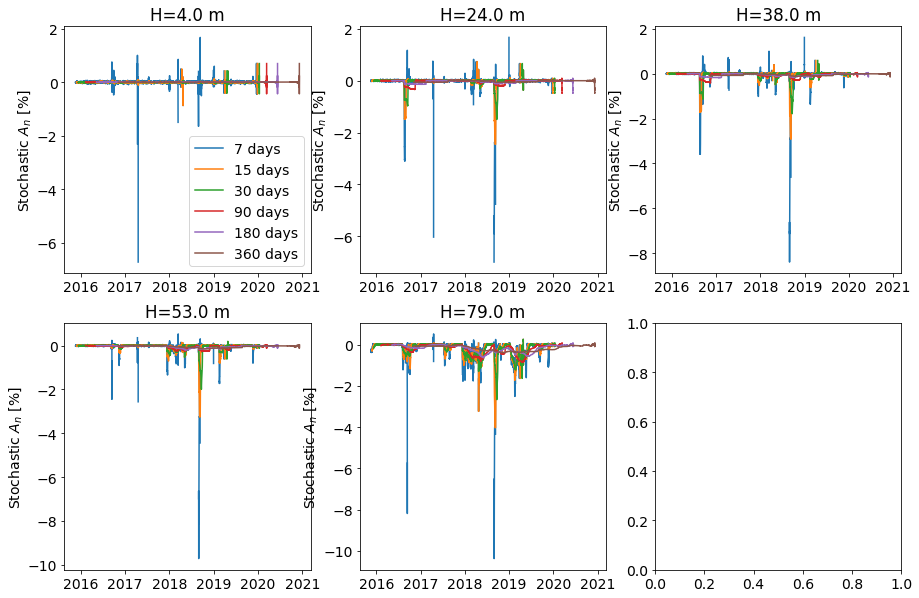

In [82]:
t1=64542#40505 #29931 # from time 1 to time 2.
t2=An_sto.shape[1]#105135

per1=np.array([7,15,30,90,180,360],dtype=int)
per=per1*24/dt

And_det=np.empty((nHeights,len(per),len(An_sto[3,][t1:t2]))) ; And_det[:]=np.nan
And_sto=np.empty((nHeights,len(per),len(An_sto[3,][t1:t2]))) ; And_sto[:]=np.nan
dif_An=np.empty((nHeights,len(per),len(An_sto[3,][t1:t2]))) ; dif_An[:]=np.nan
ETd_det=np.empty((nHeights,len(per),len(An_sto[3,][t1:t2]))) ; ETd_det[:]=np.nan
ETd_sto=np.empty((nHeights,len(per),len(An_sto[3,][t1:t2]))) ; ETd_sto[:]=np.nan
dif_ET=np.empty((nHeights,len(per),len(An_sto[3,][t1:t2]))) ; dif_ET[:]=np.nan

for j in range(nHeights):
    AnN_det=An_det[j,][t1:t2]; AnN_sto=An_sto[j,][t1:t2]  
    ETN_det=ET_det[j,][t1:t2]; ETN_sto=ET_sto[j,][t1:t2]
    for i in range(len(per)):
        #print(per1[i])
        for k in range(int(per[i]),len(AnN_det)):
            xx=AnN_det[k-int(per[i]):k]
            w=np.argwhere(np.isnan(xx))
            And_det[j,i,k]=np.nansum(AnN_det[k-int(per[i]):k])
            And_sto[j,i,k]=np.nansum(AnN_sto[k-int(per[i]):k])
            dif_An[j,i,]=1-And_det[j,i,]/And_sto[j,i,]
            xx=ETN_det[k-int(per[i]):k]
            w=np.argwhere(np.isnan(xx))
            ETd_det[j,i,k]=np.nansum(ETN_det[k-int(per[i]):k])
            ETd_sto[j,i,k]=np.nansum(ETN_sto[k-int(per[i]):k])
            dif_ET[j,i,]=1-ETd_det[j,i,]/ETd_sto[j,i,]
            
fig,axs=plt.subplots(int(np.ceil(nHeights/3)),3,figsize=(15,10))

for j in range(nHeights):
    x=int(np.floor(j/3))
    print(x)
    for i in range(len(per1)):
        axs[x,j-3*x].plot(dataf['date'][t1:t2],dif_An[j,i,]*100,label=str(per1[i])+' days')
        axs[x,j-3*x].set_ylabel('Stochastic $A_n$ [%]')
        axs[x,j-3*x].set_title('H='+str(heights[j])+' m')
        date_form=DateFormatter("%Y")
        axs[x,j-3*x].xaxis.set_major_formatter(date_form)
        axs[x,j-3*x].xaxis.set_major_locator(mdates.YearLocator(base=1))
axs[0,0].legend()


## Figures

### Contribution by time aggregation

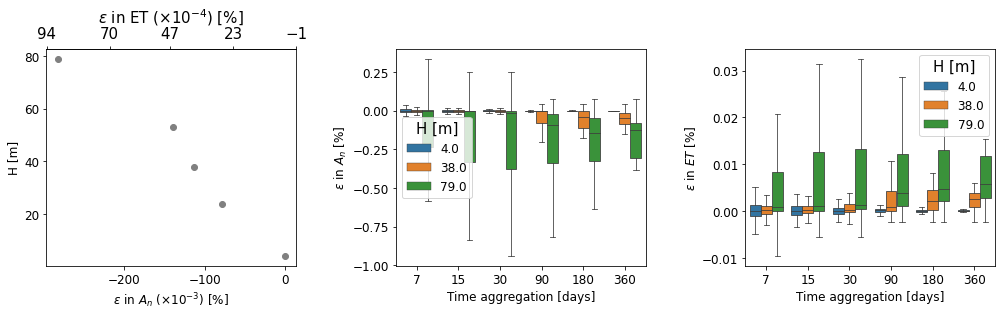

In [80]:
fig,axs=plt.subplots(1,3,figsize=(17,4))    
plt.rcParams.update({'font.size':15})    


#xold=[min(diff_An),max(diff_An)]*100*1000#diff_An*100*1000#np.linspace(diff_An[0]*100,diff_An[-1]*100, 100)
#xnew=diff_ET*100*1000#diff_ET*100*1000#np.linspace(diff_ET[0]*100*100,diff_ET[-1]*100, 100)
xold=[max(diff_An)*100*1000,min(diff_An)*100*1000]
xnew=[min(diff_ET)*100*10000,max(diff_ET)*100*10000]
def forward(x):
    return np.interp(x,xold,xnew)
def inverse(x):
    return np.interp(x,xnew,xold)
    
axs[0].plot(diff_An*100*1000,heights,'o',color='gray')
axs[0].set_xlabel(r'$\epsilon$ in $A_n$ ($\times$10$^{-3}$) [%]')
axs[0].set_ylabel('H [m]')
secax=axs[0].secondary_xaxis('top', functions=(forward,inverse))
# # #axs[0].secondary_xaxis('top',functions=(Anf,ETf))
ticks=np.round(np.linspace(np.min(diff_ET)*100*10000,np.max(diff_ET)*100*10000,5))
secax.set_xticks(ticks)
secax.set_xlabel(r'$\epsilon$ in ET ($\times$10$^{-4}$) [%]')

nt=len(dif_An[0,0,:])

nH=3 # number of heights to plot.
pH=np.round(np.linspace(0,nHeights-1,nH)) # position of heights to plot.

for i in range(len(per1)):
    for j in range(nH):
        if i==0 and j==0:df_An=pd.DataFrame({'dif':dif_An[int(pH[j]),i,:]*100,'H':np.ones(nt,dtype=int)*heights[int(pH[j])],'agg':np.ones(nt,dtype=int)*per1[i]})
        else:df_An=df_An.append(pd.DataFrame({'dif':dif_An[int(pH[j]),i,:]*100,'H':np.ones(nt,dtype=int)*heights[int(pH[j])],'agg':np.ones(nt,dtype=int)*per1[i]}))
        if i==0 and j==0:df_ET=pd.DataFrame({'dif':dif_ET[int(pH[j]),i,:]*100,'H':np.ones(nt,dtype=int)*heights[int(pH[j])],'agg':np.ones(nt,dtype=int)*per1[i]})
        else:df_ET=df_ET.append(pd.DataFrame({'dif':dif_ET[int(pH[j]),i,:]*100,'H':np.ones(nt,dtype=int)*heights[int(pH[j])],'agg':np.ones(nt,dtype=int)*per1[i]}))

sns.boxplot(x="agg",y="dif",hue="H",data=df_An,showfliers=False,linewidth=0.8,ax=axs[1])
axs[1].set_xlabel('Time aggregation [days]')
axs[1].set_ylabel(r'$\epsilon$ in $A_n$ [%]')
axs[1].legend(fontsize=12,title='H [m]')

sns.boxplot(x="agg",y="dif",hue="H",data=df_ET,showfliers=False,linewidth=0.8,ax=axs[2])
axs[2].set_xlabel('Time aggregation [days]')
axs[2].set_ylabel(r'$\epsilon$ in $ET$ [%]')
axs[2].legend(fontsize=12,title='H [m]')
plt.subplots_adjust(wspace=0.4)

fig.savefig(paths+"Sto_contribution_"+sitef+".pdf", bbox_inches='tight')

### pdfs of $A_n$ and $T$

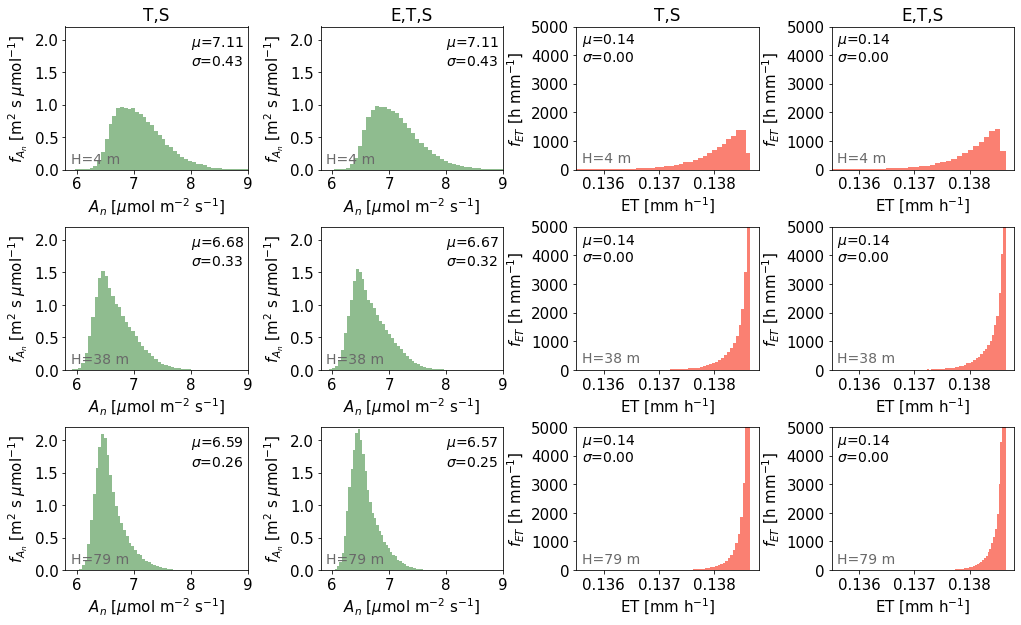

In [81]:
fig,axs=plt.subplots(3,4,figsize=(17,10))    
plt.rcParams.update({'font.size':14}) 

for i in range(2): # An or ET. 
    for j in range(2): # Deterministic or stochastic.
        if i==0: 
            xlim=[5.8,9]; ylim=[0,2.2] 
            xtit='$A_n$ [$\mu$mol m$^{-2}$ s$^{-1}$]'; ytit='$f_{A_n}$ [m$^{2}$ s $\mu$mol$^{-1}$]'
            col='darkseagreen'; x1=8; y1=1.9; y2=1.6; x2=5.9; y3=0.1
            if j==0:var=An_det/3600; tit='T,S'
            if j==1:var=An_sto/3600; tit='E,T,S'
        if i==1:
            xlim=[0.1355,0.1388]; ylim=[0,5000]; xtit='ET [mm h$^{-1}$]'; ytit='$f_{ET}$ [h mm$^{-1}$]'
            col='salmon'; x1=0.1356; y1=4400; y2=3800; x2=x1; y3=250
            if j==0:var=ET_det*1000*3600; tit='T,S'
            if j==1:var=ET_sto*1000*3600; tit='E,T,S'
        for k in range(nH): # each height.
            axs[k,i+j+i].hist(var[int(pH[k]),],bins=50,density=True,color=col)
            axs[k,i+j+i].set_xlim(xlim)
            axs[k,i+j+i].set_ylim(ylim)
            axs[k,i+j+i].set_xlabel(xtit)
            axs[k,i+j+i].set_ylabel(ytit)
            axs[k,i+j+i].text(x1,y1,'$\mu$='+str("{:.2f}".format(np.nanmean(var[int(pH[k]),]))))
            axs[k,i+j+i].text(x1,y2,'$\sigma$='+str("{:.2f}".format(np.nanstd(var[int(pH[k]),]))))
            axs[k,i+j+i].text(x2,y3,'H='+str("{:.0f}".format(heights[int(pH[k])]))+' m',color='dimgrey')
            if k==0:axs[k,i+j+i].set_title(tit)
plt.subplots_adjust(hspace=0.4,wspace=0.4)
fig.savefig(paths+"pdfs_An_ET_"+sitef+".pdf", bbox_inches='tight')